In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from keras.models import model_from_json

In [ ]:
from google.colab import drive
 
#drive.mount('/content/drive')  
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
ls '/content/gdrive/MyDrive/Data_EEG/Datos_2/DatosTotal/Paciente_ID_Ivan'

datos_paciente.txt  Gesto_2/  Gesto_4/  Gesto_6/
Gesto_1/            Gesto_3/  Gesto_5/  Gesto_7/


In [ ]:
ls '/content/gdrive/MyDrive/Data_EEG/TraDB/Persona_ID_ (1)'

datos_paciente.txt  Gesto_2/  Gesto_4/  Gesto_6/
Gesto_1/            Gesto_3/  Gesto_5/  Gesto_7/


# Se cargan los datos

In [ ]:
from glob import glob
my_dirs2 = glob("/content/gdrive/MyDrive/Data_EEG/Datos_2/DatosTotal/*/")
my_dirs2.sort()
my_dirs2


dict_gestos = ['Gesto_1','Gesto_2','Gesto_4','Gesto_5'] # 4Gestos  ['Gesto_1','Gesto_2','Gesto_4','Gesto_5']


dict_datos = glob("/content/gdrive/MyDrive/Data_EEG/Datos_2/DatosTotal/Paciente_ID_Ivan/Gesto_2/Datos_CSV_ULTRACORTEX/*")
dict_datos.sort()
dict_datos
datos = []
for i in range(len(dict_datos)):
    datos.append(f'datos_{i+1}.csv')


def Verificar_datos(my_dirs2, dict_gestos, datos):
    shapes=[]
    for i in range(len(my_dirs2)):
        for j in range(len(dict_gestos)):
            #print(my_dirs2[i]+dict_gestos[j])
            for k in range(len(datos)):
              #print(my_dirs2[i]+dict_gestos[j]+'/Datos_CSV_MYO/'+dict_datos[k])
              df = pd.read_csv(my_dirs2[i]+dict_gestos[j]+'/Datos_CSV_ULTRACORTEX/'+datos[k],encoding='ISO-8859-1', skiprows = 2,sep=';')
              shapes.append(df.shape)
              #print(i,j,df.shape)
    print(np.unique(shapes), len(shapes))
    
    from collections import Counter
    counter=Counter(shapes)
    print(counter)

features=[]
for i in range(len(my_dirs2)):
    for j in range(len(dict_gestos)):
    #print(my_dirs2[i]+dict_gestos[j])
        for k in range(len(datos)):
      #print(my_dirs2[i]+dict_gestos[j]+'/Datos_CSV_MYO/'+dict_datos[k])
          df = pd.read_csv(my_dirs2[i]+dict_gestos[j]+'/Datos_CSV_ULTRACORTEX/'+datos[k],encoding='ISO-8859-1', skiprows = 2,sep=';')
          if (df.shape[0] != 625):
                tamaño = df.shape[0]
                for ii in range(625-df.shape[0]):
                    df.loc[df.shape[0]+ii+1] = df.values[tamaño-1-ii]
          features.append(df.iloc[0:625,0:16].values)

for i in range(len(features)):    
    len(features), features[i].shape
    if (features[i].shape != (625,16)):
        print(i+1,len(features), features[i].shape)
print("All its ok!!")
print(len(features))

All its ok!!
320


Funciones para el pre-procesamiento

In [ ]:
from sklearn import preprocessing
def Escalar(features_array):
    New_scaled= []
    for values in range(features_array.shape[0]):
        X_scaled = preprocessing.scale(features_array[values])
        New_scaled.append(X_scaled)
    len(New_scaled) ,New_scaled[0].shape
    New_scaled_array = np.array(New_scaled)
    New_scaled_array.shape
    return(New_scaled_array)

def MinMax(features_array):
    New_scaled= []
    for values in range(features_array.shape[0]):
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train_minmax = min_max_scaler.fit_transform(features_array[values])
        New_scaled.append(X_train_minmax)
    len(New_scaled) ,New_scaled[0].shape
    New_scaled_array = np.array(New_scaled)
    New_scaled_array.shape
    return(New_scaled_array)

def Normalizar(features_array):
    New_scaled= []
    for values in range(features_array.shape[0]):
        X_normalized = preprocessing.normalize(features_array[values], norm='l2')
        New_scaled.append(X_normalized)
    len(New_scaled) ,New_scaled[0].shape
    New_scaled_array = np.array(New_scaled)
    New_scaled_array.shape
    return(New_scaled_array)


Matriz de confusión de colores 

In [ ]:
from sklearn.utils.multiclass import unique_labels
#y = np.repeat(np.arange(0,10),15)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix (Ivan)'
        else:
            title = 'Confusion matrix, without normalization (Ivan)'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.xlim(-0.5, len(np.unique(y))-0.5)
    #plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

Se ajustan los sets de datos con los pre-procesamientos

In [ ]:
features_array = np.array(features)
print(features_array.shape)
#features_array = features_array[:,:,[0,1,4,5,6,7,8,9,10,11,12,13,14,15]]
print(features_array.shape)
features_arrayE = Escalar(features_array)
features_arrayM = MinMax(features_array)
features_arrayN = Normalizar(features_array)

(320, 625, 16)
(320, 625, 16)


## Etiquetas de los datos

In [ ]:
long = len(dict_datos)
labels = np.concatenate((np.zeros(long),np.ones(long),np.ones(long)*2,np.ones(long)*3),axis=0)
#print(labels.shape)
def repeat(arr, count):
    return np.stack([arr for _ in range(count)], axis=0)
labels = repeat(labels,len(my_dirs2)) # Cantidad de pacientes
print(labels.shape)
print(len(features_array))
labels = np.reshape(labels,len(features_array))
labels, labels.shape

(8, 40)
320


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        2., 

# División de los sets para entrenamiento, validación y test


In [ ]:
X_train,x_test,Y_train,y_test = train_test_split(features_array,labels,train_size=0.9)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train)

# Prueabas para definir los valores de las capas

In [ ]:
Map=[4, 6, 8, 10, 12, 14, 16]
Kern = [50, 100, 150, 200, 250, 300]

## Prueba para definir los valores en la primera capa

In [ ]:

Kern2 = [50, 100, 150, 200, 250]
a = 0
Heatmap=np.zeros([7,6])
for M in Map:
  b = 0
  for k in Kern:
    

    input_shape = (625,16)
    inputs = keras.layers.Input(input_shape)
    x = keras.layers.Conv1D(M, k, activation='relu',input_shape=input_shape)(inputs)
    x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
    x = keras.layers.Conv1D(16, 80, activation='relu',input_shape=input_shape)(x)
    x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256,activation = 'relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(units=4, activation= 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs=outputs, name ='model_sing')


    checkpoint = ModelCheckpoint('MejorPrueba.h5', 
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only= True,
                                mode='auto')

    model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
    model.summary()

    history1 = model.fit(x_train,y_train, epochs= 200, validation_data=(x_val,y_val),callbacks=[checkpoint])
    data = (x_val, y_val)

    #print(history1.history['val_accuracy'])
    print(max(history1.history['val_accuracy']))
    Heatmap[a,b] = max(history1.history['val_accuracy'])
    print(Heatmap)
    b = b+1
  a = a+1

Model: "model_sing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_147 (InputLayer)       [(None, 625, 16)]         0         
_________________________________________________________________
conv1d_292 (Conv1D)          (None, 576, 4)            3204      
_________________________________________________________________
max_pooling1d_291 (MaxPoolin (None, 288, 4)            0         
_________________________________________________________________
conv1d_293 (Conv1D)          (None, 39, 16)            16016     
_________________________________________________________________
max_pooling1d_292 (MaxPoolin (None, 20, 16)            0         
_________________________________________________________________
flatten_145 (Flatten)        (None, 320)               0         
_________________________________________________________________
dense_290 (Dense)            (None, 256)               8

ValueError: ignored

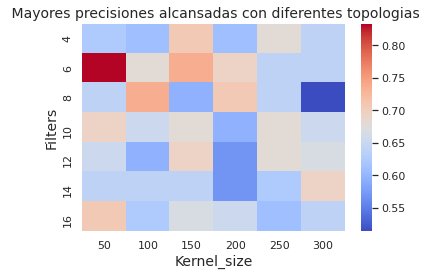

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
ax = sns.heatmap(Heatmap,cmap="coolwarm",xticklabels=Kern, yticklabels=Map)
plt.xlabel("Kernel_size", size=14)
plt.ylabel("Filters", size=14)
plt.title(" Mayores precisiones alcansadas con diferentes topologias", size=14)
plt.tight_layout()
plt.savefig('heatmap_1.2_Capa.jpg',dpi=150, figsize=(9,6))

## Prueba para definir los valores de la segunda capa

In [ ]:

Kern2 = [50, 100, 150, 200, 250]
a = 0
Heatmap2=np.zeros([7,5])
for M in Map:
  b = 0
  for k in Kern2:
    

    input_shape = (625,16)
    inputs = keras.layers.Input(input_shape)
    x = keras.layers.Conv1D(6, 50, activation='relu',input_shape=input_shape)(inputs)
    x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
    x = keras.layers.Conv1D(M, k, activation='relu',input_shape=input_shape)(x)
    x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256,activation = 'relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(units=4, activation= 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs=outputs, name ='model_sing')


    checkpoint = ModelCheckpoint('MejorPrueba.h5', 
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only= True,
                                mode='auto')

    model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
    model.summary()

    history1 = model.fit(x_train,y_train, epochs= 200, validation_data=(x_val,y_val),callbacks=[checkpoint])
    data = (x_val, y_val)

    #print(history1.history['val_accuracy'])
    print(max(history1.history['val_accuracy']))
    Heatmap2[a,b] = max(history1.history['val_accuracy'])
    print(Heatmap2)
    b = b+1
  a = a+1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
input_141 (InputLayer)       [(None, 625, 16)]         0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 576, 6)            4806      
_________________________________________________________________
max_pooling1d_279 (MaxPoolin (None, 288, 6)            0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 39, 14)            21014     
_________________________________________________________________
max_pooling1d_280 (MaxPoolin (None, 20, 14)            0         
_________________________________________________________________
flatten_139 (Flatten)        (None, 280)               0         
_________________________________________________________________
dense_278 (Dense)            (None, 256)               71936     
_________________________________________________________________
dropout_1

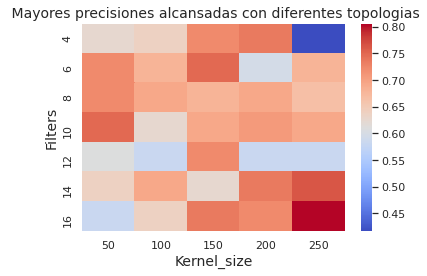

In [ ]:
ax = sns.heatmap(Heatmap2,cmap="coolwarm",xticklabels=Kern2, yticklabels=Map)
plt.xlabel("Kernel_size", size=14)
plt.ylabel("Filters", size=14)
plt.title(" Mayores precisiones alcansadas con diferentes topologias", size=14)
plt.tight_layout()
plt.savefig('heatmap_2_Capa.jpg',dpi=150, figsize=(9,6))

## Prueba para definir los valores de la capa densa

In [ ]:
drop = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
a = 0
Heatmapd=np.zeros([6,6])
for n in drop:
  b = 0
  for k in Kern:
    

    input_shape = (625,16)
    inputs = keras.layers.Input(input_shape)
    x = keras.layers.Conv1D(6, 50, activation='relu',input_shape=input_shape)(inputs)
    x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
    x = keras.layers.Conv1D(16, 250, activation='relu',input_shape=input_shape)(x)
    x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(k,activation = 'relu')(x)
    x = keras.layers.Dropout(n)(x)
    outputs = keras.layers.Dense(units=4, activation= 'softmax')(x)

    model = keras.Model(inputs = inputs, outputs=outputs, name ='model_sing')


    checkpoint = ModelCheckpoint('MejorPrueba.h5', 
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only= True,
                                mode='auto')

    model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
    model.summary()

    history1 = model.fit(x_train,y_train, epochs= 200, validation_data=(x_val,y_val),callbacks=[checkpoint])
    data = (x_val, y_val)

    #print(history1.history['val_accuracy'])
    print(max(history1.history['val_accuracy']))
    Heatmapd[a,b] = max(history1.history['val_accuracy'])
    print(Heatmapd)
    b = b+1
  a = a+1

Se truncaron las últimas líneas 5000 del resultado de transmisión.
 [0.65277779 0.72222221 0.7361111  0.66666669 0.80555558 0.75      ]
 [0.         0.         0.         0.         0.         0.        ]]
Model: "model_sing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_180 (InputLayer)       [(None, 625, 16)]         0         
_________________________________________________________________
conv1d_358 (Conv1D)          (None, 576, 6)            4806      
_________________________________________________________________
max_pooling1d_356 (MaxPoolin (None, 288, 6)            0         
_________________________________________________________________
conv1d_359 (Conv1D)          (None, 39, 16)            24016     
_________________________________________________________________
max_pooling1d_357 (MaxPoolin (None, 20, 16)            0         
________________________________________________

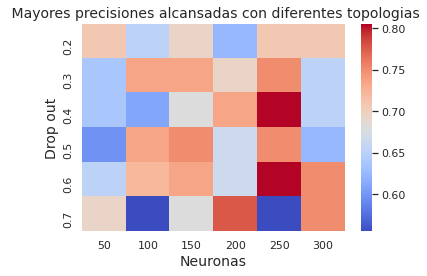

In [ ]:
ax = sns.heatmap(Heatmapd,cmap="coolwarm",xticklabels=Kern, yticklabels=drop)
plt.xlabel("Neuronas", size=14)
plt.ylabel("Drop out", size=14)
plt.title(" Mayores precisiones alcansadas con diferentes topologias", size=14)
plt.tight_layout()
plt.savefig('heatmap_d_Capa.jpg',dpi=150, figsize=(9,6))

# Entrenamiento de la red final

In [ ]:
X_train,x_test,Y_train,y_test = train_test_split(features_array,labels,train_size=0.9)
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train)

In [ ]:
input_shape = (625,16)
inputs = keras.layers.Input(input_shape)
x = keras.layers.Conv1D(6, 50, activation='relu',input_shape=input_shape)(inputs)
x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
x = keras.layers.Conv1D(16, 250, activation='relu',input_shape=input_shape)(x)
x = keras.layers.MaxPool1D(pool_size=2, strides = 2, padding = 'same')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(250,activation = 'relu')(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(units=4, activation= 'softmax')(x)

model = keras.Model(inputs = inputs, outputs=outputs, name ='model_sing')


checkpoint = ModelCheckpoint('MejorPrueba.h5', 
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only= True,
                             mode='auto')

model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "model_sing"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 625, 16)]         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 576, 6)            4806      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 288, 6)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 39, 16)            24016     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 20, 16)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               8

In [ ]:
history1 = model.fit(x_train,y_train, epochs= 300, validation_data=(x_val,y_val),callbacks=[checkpoint])
data = (x_val, y_val)

Epoch 1/300
7/7 [==============================] - 1s 53ms/step - loss: 10.1889 - accuracy: 0.2362 - val_loss: 2.6361 - val_accuracy: 0.3056

Epoch 00001: val_accuracy improved from -inf to 0.30556, saving model to MejorPrueba.h5
Epoch 2/300
7/7 [==============================] - 0s 10ms/step - loss: 3.3150 - accuracy: 0.3386 - val_loss: 1.6729 - val_accuracy: 0.4306

Epoch 00002: val_accuracy improved from 0.30556 to 0.43056, saving model to MejorPrueba.h5
Epoch 3/300
7/7 [==============================] - 0s 9ms/step - loss: 1.4102 - accuracy: 0.4427 - val_loss: 1.3983 - val_accuracy: 0.3472

Epoch 00003: val_accuracy did not improve from 0.43056
Epoch 4/300
7/7 [==============================] - 0s 9ms/step - loss: 1.1936 - accuracy: 0.4617 - val_loss: 1.3876 - val_accuracy: 0.3750

Epoch 00004: val_accuracy did not improve from 0.43056
Epoch 5/300
7/7 [==============================] - 0s 9ms/step - loss: 1.2507 - accuracy: 0.4666 - val_loss: 1.4666 - val_accuracy: 0.3889

Epoch 00

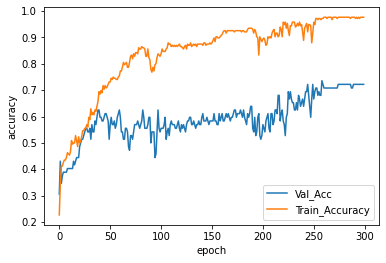

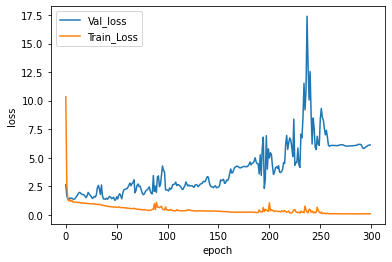

In [ ]:
model.save_weights("pesosF.h5")
plt.figure()
plt.plot(history1.history['val_accuracy'],label="Val_Acc")
plt.plot(history1.history['accuracy'],label="Train_Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid
plt.legend()
#plt.savefig("Imagenes/acc_sin.jpg")
plt.figure()
plt.plot(history1.history['val_loss'],label="Val_loss")
plt.plot(history1.history['loss'],label="Train_Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid
plt.legend()
#plt.savefig("Imagenes/loss_sin.jpg")

[3 3 3 3 1 1 2 3 3 3 3 3 3 3 3 1 0 3 1 3 3 3 1 3 3 1 3 3 3 1 0 1]
[2. 3. 3. 3. 1. 1. 0. 2. 0. 3. 2. 2. 1. 3. 3. 1. 0. 3. 1. 1. 1. 2. 1. 3.
 3. 1. 3. 0. 0. 2. 2. 1.]
(32, 625, 16)


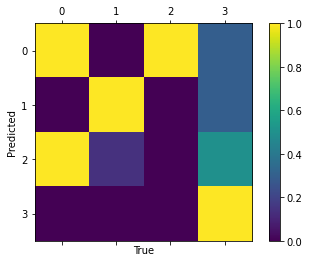

Normalized confusion matrix
[[0.2        0.         0.2        0.6       ]
 [0.         0.7        0.         0.3       ]
 [0.14285714 0.14285714 0.         0.71428571]
 [0.         0.         0.         1.        ]]


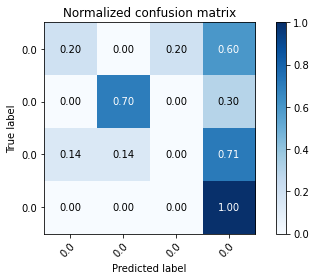

In [ ]:
class_pred = model.predict(x_test, batch_size=32)
class_pred = np.argmax(class_pred, axis=1)
print(class_pred)
print(y_test)
print(x_test.shape)
confusion_matrix(y_test, class_pred)
type(y_test)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test,class_pred)
mat = mat/np.max(mat,axis=0) #normaliza
plt.matshow(mat,fignum=False)
plt.colorbar()
plt.cm.Blues
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

plot_confusion_matrix(y_test.astype(int), class_pred.astype(int), classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Creación del mapa de cajas y bigotes

In [ ]:
from sklearn import metrics

from sklearn.metrics import precision_recall_fscore_support
fea = {
    'a': features_array,
    'b': features_arrayE,
    'c': features_arrayM,
    'd': features_arrayN
}


In [ ]:
R = ['a','b','c','d']
metric=[]
oaf=[]
for i in R:
  featur = fea.get(i)
  perf_metrics=[]
  oas=[]
  for k in range(6):
    X_train,x_test,Y_train,y_test = train_test_split(featur,labels,train_size=0.9)
    x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train)
    #x_train,x_val,y_train,y_val = train_test_split(featur,labels)
    history1 = model.fit(x_train,y_train, epochs= 200, validation_data=(x_val,y_val),callbacks=[checkpoint])
    data = (x_val, y_val)
    class_pred = model.predict(x_test, batch_size=32)
    prediction_test = np.argmax(class_pred, axis=1)
    cnf_matrix = confusion_matrix(y_test, prediction_test)
    #oa = model.score(x_test, y_test)
    metrics=precision_recall_fscore_support(y_test, prediction_test, average='macro')
    perf_metrics.append(metrics[:-1])
    #oas.append(oa)
  metric.append(perf_metrics)
  #oaf.append(oas)

Epoch 1/200
19/19 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.1946 - val_loss: nan - val_accuracy: 0.1773

Epoch 00001: val_accuracy improved from -inf to 0.17734, saving model to MejorPrueba.h5
Epoch 2/200
19/19 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2420 - val_loss: nan - val_accuracy: 0.1773

Epoch 00002: val_accuracy did not improve from 0.17734
Epoch 3/200
19/19 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2036 - val_loss: nan - val_accuracy: 0.1773

Epoch 00003: val_accuracy did not improve from 0.17734
Epoch 4/200
19/19 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.2159 - val_loss: nan - val_accuracy: 0.1773

Epoch 00004: val_accuracy did not improve from 0.17734
Epoch 5/200
19/19 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1904 - val_loss: nan - val_accuracy: 0.1773

Epoch 00005: val_accuracy did not improve from 0.17734
Epoch 6/200

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 151/200
19/19 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1911 - val_loss: nan - val_accuracy: 0.1921

Epoch 00151: val_accuracy did not improve from 0.25123
Epoch 152/200
19/19 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.1911 - val_loss: nan - val_accuracy: 0.1921

Epoch 00152: val_accuracy did not improve from 0.25123
Epoch 153/200
19/19 [==============================] - 0s 15ms/step - loss: nan - accuracy: 0.1911 - val_loss: nan - val_accuracy: 0.1921

Epoch 00153: val_accuracy did not improve from 0.25123
Epoch 154/200
19/19 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1911 - val_loss: nan - val_accuracy: 0.1921

Epoch 00154: val_accuracy did not improve from 0.25123
Epoch 155/200
19/19 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.1911 - val_loss: nan - val_accuracy: 0.1921

Epoch 00155: val_accuracy di

In [ ]:
METRIC= metric

In [ ]:
perf_metrics = np.array(METRIC)
print(perf_metrics.shape)
perf_metrics.resize(24,3)
perf_metric = np.column_stack((perf_metrics))
perf_metric.resize(72,)
print(perf_metrics)

(4, 6, 3)
[[0.03111111 0.2        0.05384615]
 [0.03333333 0.2        0.05714286]
 [0.03111111 0.2        0.05384615]
 [0.04666667 0.2        0.07567568]
 [0.04222222 0.2        0.06972477]
 [0.04222222 0.2        0.06972477]
 [0.03111111 0.2        0.05384615]
 [0.04222222 0.2        0.06972477]
 [0.03111111 0.2        0.05384615]
 [0.02444444 0.2        0.04356436]
 [0.04       0.2        0.06666667]
 [0.04888889 0.2        0.07857143]
 [0.05555556 0.2        0.08695652]
 [0.04444444 0.2        0.07272727]
 [0.03333333 0.2        0.05714286]
 [0.05111111 0.2        0.08141593]
 [0.04222222 0.2        0.06972477]
 [0.05555556 0.2        0.08695652]
 [0.03555556 0.2        0.06037736]
 [0.03111111 0.2        0.05384615]
 [0.03333333 0.2        0.05714286]
 [0.03111111 0.2        0.05384615]
 [0.04444444 0.2        0.07272727]
 [0.03333333 0.2        0.05714286]]


In [ ]:
F1_Score=[]
for i in range(24):
  F1_Score.append(2*(perf_metrics[i,1]*perf_metrics[i,2])/(perf_metrics[i,1]+perf_metrics[i,2]))
f1_score = np.array(F1_Score)
print(f1_score)

[0.08484848 0.08888889 0.08484848 0.10980392 0.10340136 0.10340136
 0.08484848 0.10340136 0.08484848 0.07154472 0.1        0.11282051
 0.12121212 0.10666667 0.08888889 0.11572327 0.10340136 0.12121212
 0.09275362 0.08484848 0.08888889 0.08484848 0.10666667 0.08888889]


In [ ]:
#labels / methods + metrics
method1 = np.repeat('CNN_alpha',6)
method2 = np.repeat('CNN_Escalar',6)
method3 = np.repeat('CNN_Min-Max',6)
method4 = np.repeat('CNN_Normalizar',6)
method = np.concatenate((method1,method2,method3,method4),axis=0)
methods = np.concatenate((method,method,method,method),axis=0)

metric1 = np.repeat('Overall Accuracy',24)
metric2 = np.repeat('Precision',24)
metric3 = np.repeat('Recall',24)
metric4 = np.repeat('f1-score',24)
metric = np.concatenate((metric1,metric2,metric3,metric4),axis=0)

values = np.concatenate((f1_score,perf_metric),axis=0)

In [ ]:
methods.shape, metric.shape, values.shape

((96,), (96,), (96,))

In [ ]:
data = {'Method': methods,
        'Metrics': metric,
        'Values': values,
        }
df = pd.DataFrame(data, columns = ['Method', 'Metrics', 'Values'])
df.head(30)

,Method,Metrics,Values
0,CNN_alpha,Overall Accuracy,0.084848
1,CNN_alpha,Overall Accuracy,0.088889
2,CNN_alpha,Overall Accuracy,0.084848
3,CNN_alpha,Overall Accuracy,0.109804
4,CNN_alpha,Overall Accuracy,0.103401
5,CNN_alpha,Overall Accuracy,0.103401
6,CNN_Escalar,Overall Accuracy,0.084848
7,CNN_Escalar,Overall Accuracy,0.103401
8,CNN_Escalar,Overall Accuracy,0.084848
9,CNN_Escalar,Overall Accuracy,0.071545


In [ ]:
import plotly.express as px
fig = px.box(df, x="Method", y="Values", color="Metrics")
plt.figure(figsize=(20,10))
#fig.write_image("boxplot1.svg")
#plt.savefig("Imagenes/Paradigmas2")
fig.show()

<Figure size 1440x720 with 0 Axes>

## Pruebas con datos obtenidos a mano

In [ ]:
y = [0.10666667, 0.2       , 0.3964539 , 0.2964539 , 0.11572327, 0.10980392,
 0.1964539 , 0.11282051, 0.10340136, 0.19       , 0.2964539 , 0.12121212,
 0.10666667, 0.08062016, 0.10980392, 0.10340136, 0.08062016, 0.10666667,
 0.08888889, 0.1980392, 0.311282051, 0.29275362, 0.1964539 , 0.10666667,
 0.24444444, 0.5     , 0.86, 0.4, 0.05111111, 0.6,
 0.3377778, 0.5, 0.5, 0.2      , 0.49, 0.25555556,
 0.04444444, 0.02888889, 0.04666667, 0.04222222, 0.02888889, 0.04444444,
 0.533333, 0.4666667, 0.64888889, 0.3555556, 0.6777778, 0.54444444,
 0.81       , 0.7       , 0.4       , 0.1       , 0.4        ,0.2,
 0.27       , 0.4       , 0.7       , 0.23       , 0.32        ,0.2,
 0.2       , 0.2       , 0.2       , 0.2       , 0.2       , 0.2,
 0.62       , 0.7       , 0.5       , 0.55       , 0.2       , 0.22,
 0.7272727, 0.56666667, 0.435514 , 0.0635514 , 0.08141593, 0.47567568,
 0.3035514 , 0.45857143, 0.26972477, 0.06666667, 0.3635514 , 0.08695652,
 0.07272727, 0.05048544, 0.07567568, 0.06972477, 0.05048544, 0.07272727,
 0.5714286, 0.47567568, 0.57857143, 0.6037736, 0.3635514 , 0.27272727]
y = np.array(y)

SyntaxError: ignored

In [ ]:
methods.shape, metric.shape, y.shape

((96,), (96,), (96,))

In [ ]:
data2 = {'Method': methods,
        'Metrics': metric,
        'Values': y,
        }
df = pd.DataFrame(data2, columns = ['Method', 'Metrics', 'Values'])
df.head(30)

,Method,Metrics,Values
0,CNN_alpha,Overall Accuracy,0.106667
1,CNN_alpha,Overall Accuracy,0.200000
2,CNN_alpha,Overall Accuracy,0.396454
3,CNN_alpha,Overall Accuracy,0.296454
4,CNN_alpha,Overall Accuracy,0.115723
5,CNN_alpha,Overall Accuracy,0.109804
6,CNN_Escalar,Overall Accuracy,0.196454
7,CNN_Escalar,Overall Accuracy,0.112821
8,CNN_Escalar,Overall Accuracy,0.103401
9,CNN_Escalar,Overall Accuracy,0.190000


In [ ]:
import plotly.express as px
fig = px.box(df, x="Method", y="Values", color="Metrics")
plt.figure(figsize=(20,10))
#fig.write_image("boxplot1.svg")
#plt.savefig("Imagenes/Paradigmas2")
fig.show()

<Figure size 1440x720 with 0 Axes>

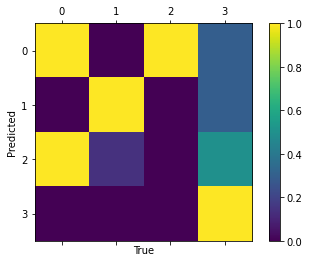

Normalized confusion matrix
[[0.5 0.  0.3 0.2]
 [0.3 0.3 0.4 0. ]
 [0.  0.4 0.4 0.2]
 [0.2 0.1 0.2 0.5]]


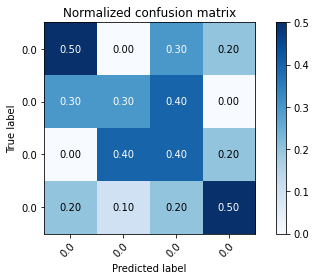

In [ ]:
TC = np.array([0,0,0,0,0,0,0,0,0,0,
 1,1,1,1,1,1,1,1,1,1,
 2,2,2,2,2,2,2,2,2,2,
 3,3,3,3,3,3,3,3,3,3])
PC1 = np.array([3,2,2,0,0,0,0,3,0,2,
 2,2,1,2,2,1,1,0,0,0,
 2,1,2,2,1,3,1,1,2,3,
 3,3,2,0,3,1,3,0,2,3])
PC2 = np.array([0,0,3,3,0,0,3,0,0,0,
 1,1,1,1,1,1,3,1,1,1,
 0,1,1,1,1,1,3,1,0,3,
 3,0,0,1,3,3,0,3,0,3])
plt.matshow(mat,fignum=False)
plt.colorbar()
plt.cm.Blues
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

plot_confusion_matrix(TC.astype(int), PC1.astype(int), classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

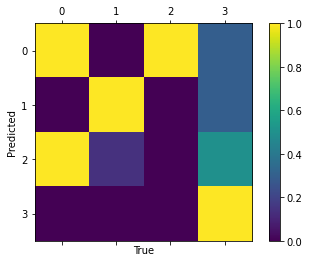

Normalized confusion matrix
[[0.7 0.  0.  0.3]
 [0.  0.9 0.  0.1]
 [0.2 0.6 0.  0.2]
 [0.4 0.1 0.  0.5]]


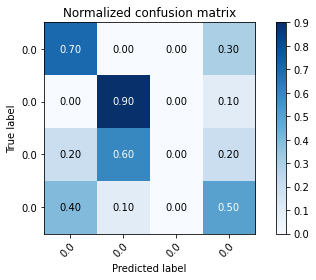

In [ ]:
plt.matshow(mat,fignum=False)
plt.colorbar()
plt.cm.Blues
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

plot_confusion_matrix(TC.astype(int), PC2.astype(int), classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.show()